# Visualization

In [82]:
# Venv at: Studienarbeit/Model/SwinVE/bin/activate
import os
import json
import shutil
import tempfile
import time

import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib

from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai import transforms
from monai.transforms import (
    AsDiscrete,
    Activations,
)

from monai.config import print_config
from monai.metrics import DiceMetric
from monai.utils.enums import MetricReduction
from monai.networks.nets import SwinUNETR
from monai import data
from monai.data import decollate_batch
from functools import partial
import wandb

import torch
import tifffile as tiff


from PIL import Image
from importlib import reload
from glob import glob
from natsort import natsorted
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit
from torch.utils.data import Dataset, DataLoader

import utils_UNETR
import dataset_UNETR
import augmentations_UNETR
import train_UNETR
import metrics_UNETR
import unet
import augmentations_exp3
reload(augmentations_exp3)
reload(utils_UNETR)
reload(dataset_UNETR)
reload(augmentations_UNETR)
reload(train_UNETR)
reload(metrics_UNETR)
from utils_UNETR import *
from dataset_UNETR import *
from augmentations_UNETR import *
from train_UNETR import *
from metrics_UNETR import *
from unet import *
from augmentations_exp3 import *


#### Prepare multi-temporal dataset

In [83]:
DATA_PATH = "../../data_creation/data_pipeline"
target_size = (128, 128, 32)
target_size_mono = (128, 128)
SEED = 42
n_classes = 1 # Probability for each pixel to be a crack
target_width=target_size[0]
target_height=target_size[1]
list_mt_images = glob(os.path.join(DATA_PATH, "multi-temporal_data_only_7-8", "mt-images", "*.npy"), recursive=True)
list_mt_images = natsorted(list_mt_images, key=lambda y: y.lower())

list_mt_targets = glob(os.path.join(DATA_PATH, "multi-temporal_data_only_7-8", "mt-targets", "*.npy"), recursive=True)
list_mt_targets = natsorted(list_mt_targets, key=lambda y: y.lower())

df, _ = df_for_all_samples_mt(DATA_PATH, testset_size = 0.2, valset_size = 0.2, SEED = 42)
crack_images = df[df['crack'] != 0]

no_crack_images = df[df['crack'] == 0]

print(f"Ratio of crack images to no crack images in original dataset: {len(crack_images)/len(no_crack_images)}.")

ratio = 2/3
num_total_images = int(len(crack_images)/ratio)
diff_no_crack_images = num_total_images - len(crack_images)
print(f"The crack images need to be extended by {diff_no_crack_images} no crack images to achieve a ratio of {round(100*ratio,2)}% crack images to no crack images.")

selected_no_crack_images = no_crack_images.sample(n = diff_no_crack_images, random_state = SEED)
new_df = pd.concat([crack_images, selected_no_crack_images]).reset_index(drop=True)

Ratio of crack images to no crack images in original dataset: 0.19120135363790186.
The crack images need to be extended by 452 no crack images to achieve a ratio of 66.67% crack images to no crack images.


In [84]:
new_df

path_image  \
0     ../../data_creation/data_pipeline/multi-tempor...   
1     ../../data_creation/data_pipeline/multi-tempor...   
2     ../../data_creation/data_pipeline/multi-tempor...   
3     ../../data_creation/data_pipeline/multi-tempor...   
4     ../../data_creation/data_pipeline/multi-tempor...   
...                                                 ...   
1351  ../../data_creation/data_pipeline/multi-tempor...   
1352  ../../data_creation/data_pipeline/multi-tempor...   
1353  ../../data_creation/data_pipeline/multi-tempor...   
1354  ../../data_creation/data_pipeline/multi-tempor...   
1355  ../../data_creation/data_pipeline/multi-tempor...   

                                            path_target  crack  num_pixels  
0     ../../data_creation/data_pipeline/multi-tempor...      1         100  
1     ../../data_creation/data_pipeline/multi-tempor...      1           7  
2     ../../data_creation/data_pipeline/multi-tempor...      1          40  
3     ../../data_creation/data_pipeline/multi-tempor...      1         220  
4     ../../data_creation/data_pipeline/multi-tempor...      1         143  
...                                                 ...    ...         ...  
1351  ../../data_creation/data_pipeline/multi-tempor...      0           0  
1352  ../../data_creation/data_pipeline/multi-tempor...      0           0  
1353  ../../data_creation/data_pipeline/multi-tempor...      0           0  
1354  ../../data_creation/data_pipeline/multi-tempor...      0           0  
1355  ../../data_creation/data_pipeline/multi-tempor...      0           0  

[1356 rows x 4 columns]

#### Multi-temporal dataset

In [85]:
print("Multi-temporal Dataset \n")
train, val, test = create_splits(new_df, testset_size = 0.2, valset_size = 0.2, SEED = SEED, target_size = target_size)

train_images = train["path_image"]
train_images = natsorted(train_images, key=lambda y: y.lower())
train_targets = train["path_target"]
train_targets = natsorted(train_targets, key=lambda y: y.lower())

val_images = val["path_image"]
val_images = natsorted(val_images, key=lambda y: y.lower())
val_targets = val["path_target"]
val_targets = natsorted(val_targets, key=lambda y: y.lower())

test_images = test["path_image"]
test_images = natsorted(test_images, key=lambda y: y.lower())
test_targets = test["path_target"]
test_targets = natsorted(test_targets, key=lambda y: y.lower())

Multi-temporal Dataset 

Training
Ratio of crack images to all images: 66.54 %
Ratio of crack pixels to all pixels: 1.25 %
Number of samples: 813

Validation
Ratio of crack images to all images: 66.79 %
Ratio of crack pixels to all pixels: 1.29 %
Number of samples: 271

Testing
Ratio of crack images to all images: 66.91 %
Ratio of crack pixels to all pixels: 1.21 %
Number of samples: 272



In [86]:
test_mt_dataset = MtCrackDataset(test_images, test_targets)

#### Load best UNet and SwinUNetR 

In [87]:
model_swin = SwinUNETR(
    img_size=target_size,
    in_channels=3,
    out_channels=1,
    feature_size=24,
    drop_rate=0.0,
    attn_drop_rate=0.0,
    dropout_path_rate=0.0,
    use_checkpoint=True,
)
model_name = "model_nrepochs_96_sig_0-5.pth"
model_checkpoint = os.path.join("TrainedModels", "SwinUNetR1-96", model_name)
checkpoint = torch.load(model_checkpoint, map_location=torch.device('cpu'))

model_swin.load_state_dict(checkpoint['model_state_dict'])
model_swin.eval()
print("Loaded SwinUNetR model from {}.".format(model_checkpoint))

Loaded SwinUNetR model from TrainedModels/SwinUNetR1-96/model_nrepochs_96_sig_0-5.pth.


In [88]:
model_unet = UNet(1)
model_checkpoint = os.path.join('../UNet/Trained_Models/Official_Models/UNet5-55/model_nrepochs_55_sig_0-5.pth')
checkpoint = torch.load(model_checkpoint, map_location=torch.device('cpu'))
model_unet.load_state_dict(checkpoint['model_state_dict'])
model_unet.eval()
print("Loaded UNet model from {}.".format(model_checkpoint))

Loaded UNet model from ../UNet/Trained_Models/Official_Models/UNet5-55/model_nrepochs_55_sig_0-5.pth.


In [89]:
models = {"U-Net": model_unet, "SwinUNETR": model_swin}

#### Visualize predictions

In [90]:
def create_figure_with_adjusted_size(nrows, ncols):
    width_factor =3
    height_factor = 3
    figsize = (ncols * width_factor, nrows * height_factor)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    return fig, axes

In [91]:
def visualize_pred(model_dict, mt_dataset, patch_index, sequence, name, sigmoid_threshold = 0.5):
    mt_image, mt_target = mt_dataset[patch_index]
    mt_image = mt_image.unsqueeze(0)
    prediction_dict = {}
    
    for model_name, model in model_dict.items():
        if model_name.startswith("U-Net"):
            prediction_dict[model_name] = []
            
            for seq_index in sequence:
                output = model(mt_image[:,:,:,:,seq_index])
                output = torch.sigmoid(output) > sigmoid_threshold
                output = output.int().squeeze(0).permute(1, 2, 0)
                output = output.numpy().astype(np.uint8)
                
                prediction_dict[model_name].append(output)

        if model_name.startswith("SwinUNETR"):
            prediction_dict[model_name] = []
            
            output = model(mt_image)
            output = torch.sigmoid(output) > sigmoid_threshold
            output = output.int().squeeze(0).permute(3, 1, 2, 0)
            output = output.numpy().astype(np.uint8)
            
            for seq_index in sequence:
                prediction_dict[model_name].append(output[seq_index,:,:,:])
                
    mt_image = mt_image.squeeze(0).permute(3, 1, 2, 0).numpy()
    mt_target = mt_target.permute(3, 1, 2, 0).numpy()

    num_models = len(models.keys())
    fig, axes = create_figure_with_adjusted_size(len(sequence), num_models + 2)
    for i, time_step in enumerate(sequence):

        axes[i, 0].imshow(mt_image[time_step, :, :, :])
        axes[i, 0].set_title('Input t = {}'.format(time_step))
        axes[i, 0].axis('off')  
        
        axes[i, 1].imshow(mt_target[time_step, :, :, :], cmap='gray')
        axes[i, 1].set_title('Target t = {}'.format(time_step))
        axes[i, 1].axis('off') 
        for j, (model_name, prediction) in enumerate(prediction_dict.items()):
            ax = axes[i, j+2]
            ax.imshow(prediction[i], cmap='gray')
            ax.set_title('{} t = {}'.format(model_name, time_step))
            ax.axis('off')  

    plt.tight_layout()
    plt.savefig("Sequence_images/" + name + ".png", dpi =300)

#### Images with most crack pixels for visualization

In [92]:
test_sorted = test.loc[natsorted(test.index, key=lambda x: test.loc[x, 'path_image'].lower())]
test_sorted.reset_index(drop=True, inplace=True)
test_images = test_sorted["path_image"]
test_targets = test_sorted["path_target"]
top_10_crack_rows = test_sorted.nlargest(10, 'num_pixels')
top_10_crack_rows

path_image  \
246  ../../data_creation/data_pipeline/multi-tempor...   
43   ../../data_creation/data_pipeline/multi-tempor...   
40   ../../data_creation/data_pipeline/multi-tempor...   
249  ../../data_creation/data_pipeline/multi-tempor...   
95   ../../data_creation/data_pipeline/multi-tempor...   
137  ../../data_creation/data_pipeline/multi-tempor...   
83   ../../data_creation/data_pipeline/multi-tempor...   
108  ../../data_creation/data_pipeline/multi-tempor...   
61   ../../data_creation/data_pipeline/multi-tempor...   
148  ../../data_creation/data_pipeline/multi-tempor...   

                                           path_target  crack  num_pixels  \
246  ../../data_creation/data_pipeline/multi-tempor...      1       49849   
43   ../../data_creation/data_pipeline/multi-tempor...      1       47167   
40   ../../data_creation/data_pipeline/multi-tempor...      1       39495   
249  ../../data_creation/data_pipeline/multi-tempor...      1       38381   
95   ../../data_creation/data_pipeline/multi-tempor...      1       36882   
137  ../../data_creation/data_pipeline/multi-tempor...      1       34272   
83   ../../data_creation/data_pipeline/multi-tempor...      1       34091   
108  ../../data_creation/data_pipeline/multi-tempor...      1       33343   
61   ../../data_creation/data_pipeline/multi-tempor...      1       29873   
148  ../../data_creation/data_pipeline/multi-tempor...      1       29293   

     crack_pixel_bins  
246                18  
43                 18  
40                 18  
249                18  
95                 18  
137                18  
83                 18  
108                18  
61                 18  
148                18

#### Visualization

TypeError: can only concatenate str (not "int") to str

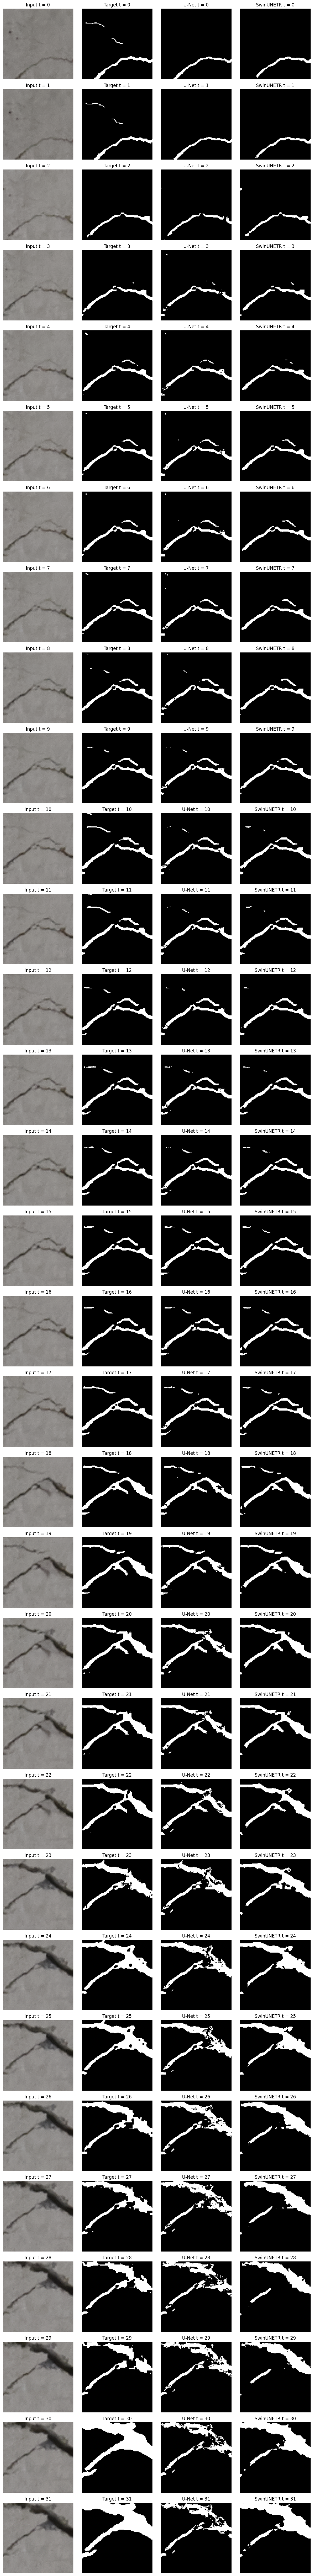

In [93]:
visualize_pred(models, test_mt_dataset, 246, range(0,32),3781)

#### Create prediction mask for all images

Reshaped images have a size of (8192, 11264, 3)(H, W, C)(Numpy).

Output masks have size of (32, 128, 128, 1)

In [35]:
list_mt_images = glob(os.path.join(DATA_PATH, "multi-temporal_data_only_7-8", "mt-images", "*.npy"), recursive=True)
list_mt_images = natsorted(list_mt_images, key=lambda y: y.lower())

list_mt_targets = glob(os.path.join(DATA_PATH, "multi-temporal_data_only_7-8", "mt-targets", "*.npy"), recursive=True)
list_mt_targets = natsorted(list_mt_targets, key=lambda y: y.lower())

In [36]:
print(len(list_mt_images))
print(len(list_mt_targets))

5632
5632


In [37]:
all_samples_mt_dataset = MtCrackDataset(list_mt_images, list_mt_targets)

In [39]:
def infer_all_samples(SwinUNetR, UNet, sample_dataset, sigmoid_threshold = 0.5):
    start_time = time.time()
    column_swin = []
    column_unet = []
    column_target = []
    
    col_counter = 0
    for i, (image, target) in enumerate(sample_dataset):
        print(f"{i+1}/{len(sample_dataset)}", end = "\r")

        image = image.unsqueeze(0)

        # Targets
#        target = target.permute(3, 1, 2, 0).numpy().astype(np.uint8)
 #       column_target.append(target)

        # SwinUNetR
#        output = SwinUNetR(image)
 #       output = torch.sigmoid(output) > sigmoid_threshold
  #      output = output.int().squeeze(0).permute(3, 1, 2, 0)
   #     output = output.numpy().astype(np.uint8)
    #    column_swin.append(output)

        # UNet
        unet_pillar = np.empty((32, 128, 128, 1), dtype=np.uint8)
        for j in range(32):
            output_unet = UNet(image[:,:,:,:,j])
            output_unet = torch.sigmoid(output_unet) > sigmoid_threshold
            output_unet = output_unet.int().squeeze(0).permute(1, 2, 0) # (H, W, C)
            output_unet = output_unet.numpy().astype(np.uint8)
            unet_pillar[j] = output_unet
        column_unet.append(unet_pillar)
        
        if (i+1)%64 == 0 and i != 0:
            # SwinUNetR
 #           col_swin = np.concatenate(column_swin, axis = 1) # (T, H, W, C) in numpy -> Column is H
  #          np.save(f"Columns_Swin/col_swin_{col_counter}", col_swin)
   #         column_swin = []

            # Targets
   #         col_target = np.concatenate(column_target, axis = 1) 
    #        np.save(f"Columns_Targets/col_target_{col_counter}", col_target)
     #       column_target = []

            # UNet
            col_unet = np.concatenate(column_unet, axis = 1) 
            np.save(f"Columns_UNet/col_unet_{col_counter}", col_unet)
            column_unet = []

            col_counter += 1
    duration = time.time() - start_time
    print("5632/5632")
    print(f"Duration: {duration} minutes.")

infer_all_samples(model_swin, model_unet, all_samples_mt_dataset, 0.5)

KeyboardInterrupt: 

In [15]:
swin_cols = glob(os.path.join("Columns_Swin", "*.npy"), recursive=True)
swin_cols = natsorted(swin_cols, key=lambda y: y.lower())

unet_cols = glob(os.path.join("Columns_UNet", "*.npy"), recursive=True)
unet_cols = natsorted(unet_cols, key=lambda y: y.lower())

target_cols = glob(os.path.join("Columns_Targets", "*.npy"), recursive=True)
target_cols = natsorted(target_cols, key=lambda y: y.lower())

swin_col_list = []
unet_col_list = []
target_col_list = []

In [19]:
for i in range(88):
    
    target_col = np.load(target_cols[i])
    target_col_list.append(target_col)
targets = np.concatenate(target_col_list, axis = 2) 
np.save("Targets", targets)

In [20]:
for i in range(88):
    swin_col = np.load(swin_cols[i])
    swin_col_list.append(swin_col)
swin_predictions = np.concatenate(swin_col_list, axis = 2)
np.save("Swin_Predictions", swin_predictions)

In [22]:
for i in range(88):
    unet_col = np.load(unet_cols[i])
    unet_col_list.append(unet_col)
unet_predictions = np.concatenate(unet_col_list, axis = 2) 
np.save("UNet_Predictions", unet_predictions)

In [28]:
a = np.load(unet_cols[0])
print(a.shape)
b = np.load(swin_cols[0])
print(b.shape)

(32, 8064, 128, 3)
(32, 8064, 128, 1)


In [ ]:
swin_preds = np.load("Swin_Predictions")
unet_preds = np.load("UNet_Predictions")
trgt = np.load("Targets")
epoch_list = [
    "790", "790_copy", "800", "810", "820",
    "830", "830_copy", "840", "850", "860",
    "870", "870_copy", "880", "890", "900",
    "910", "910_copy", "920", "930", "940",
    "950", "950_copy", "960", "970", "980",
    "980_copy", "990", "1000", "1010", "1020",
    "1026", "1026_copy"]
for i, epoch_number in enumerate(epoch_list):
    tiff.imwrite(f"Swin_Predictions/SwinUNetR_prediction_epoch_{epoch_number}.tif", swin_preds[i])
    tiff.imwrite(f"UNet_Predictions/UNet_prediction_epoch_{epoch_number}.tif", unet_preds[i])
    tiff.imwrite(f"Targets/Target_n_epoch_{epoch_number}.tif", trgt[i])
    
    

In [24]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import tifffile as tiff

In [32]:
input_image = Image.open("../../Target_epoch_790_copy.tif")
input_image = np.array(input_image)

In [33]:
print(np.unique(input_image))
print(input_image.sum())

[0 1]
109326


In [34]:
scaled_image = input_image * 255
tiff.imwrite('../../lol2.tiff', scaled_image)

In [10]:
image_path = "../../data_creation/data_pipeline/images_patches/2023-09-27-Weimar-Deformation-Epoch7to8-1026-128x128"

In [8]:
model_path = "../../data_creation/Models/model_nrepochs_213_sig_0-5.pth"
model = UNet(1)
checkpoint = torch.load(model_path, map_location=torch.device('cpu')) # remove map location in cluster
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
o=1

In [78]:
def create_prediction_mask(model, image_patch_dir, threshold = 0.5):
    print(image_patch_dir)
    image_dataset = ImageDataset(image_patch_dir)
    start_time = time.time()
    prediction_list = []
    x=[]
    y=[]
    for i in [3781] : #range(3000,len(image_dataset))

        image = image_dataset[i]
        image=image.unsqueeze(dim=0)
        prediction = model(image)
        prediction = (prediction > threshold).float()
        prediction = prediction.detach().squeeze().numpy().astype(np.uint8)

        image = image.squeeze()
        print(i)
        print(np.sum(prediction))
        if np.sum(prediction) > 0:
            plt.figure(figsize=(10, 5))
    
            plt.subplot(1, 2, 1)
            plt.imshow(image.permute(1, 2, 0).numpy())  # Assuming the image is in (C, H, W) format
            plt.title('Input Image')
            plt.axis('off')
    
            plt.subplot(1, 2, 2)
            plt.imshow(prediction, cmap='gray')
            plt.title('Predicted Segmentation Mask')
            plt.axis('off')
    
            plt.show()
#        image_np = image.permute(1, 2, 0).numpy()  
 #       image_np = (image_np * 255).astype(np.uint8)
  #      image_pil = Image.fromarray(image_np)
   #     image_pil.save(f'Errors/image_{i}.png')
    #    prediction_pil = Image.fromarray(prediction * 255)  # Convert binary mask (0/1) to grayscale (0/255)
     #   prediction_pil.save(f'Errors/prediction_{i}.png')



../../data_creation/data_pipeline/images_patches/2023-09-27-Weimar-Deformation-Epoch7to8-1026-128x128
3781
2705


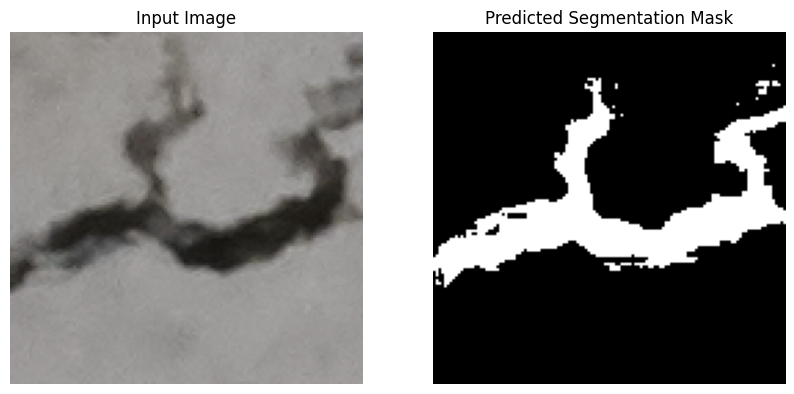

In [79]:
create_prediction_mask(model, image_path)

In [13]:
class ImageDataset(Dataset):
    def __init__(self, root, transform = ToTensorOnlyImages()):
        self.root = root
        images_paths = root
        
        list_images = glob(os.path.join(images_paths, "*.png"), recursive=True)
        list_images = natsorted(list_images, key=lambda y: y.lower())
        
        self.image_paths = list_images # dataframe["path_image"]
        self.transform = transform

    def __len__(self):
        return(len(self.image_paths))

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx])
        if self.transform:
            image = self.transform(image)
        return image

    def get_image_path(self, idx):
        return(self.image_paths[idx])

    def visualize(self, idx):
        image = Image.open(self.image_paths[idx])
        if self.transform:
            image = self.transform(image)
        
        image = image.permute(1, 2, 0).numpy()  # Change order to HxWxC
        
        fig, ax = plt.subplots(1, 1, figsize=(6, 6))
        ax.imshow(image)
        ax.set_title('Image')
        ax.axis('off')
        plt.show()

In [12]:
class ToTensorOnlyImages(object):
    def __call__(self, image):
        #image = sample["image"]
        image = np.array(image)
        image = image.transpose((2, 0, 1))
        image=torch.from_numpy(image)
        image = image.float()/255.0
        
        return image